In [1]:
import sys
import numpy as np
from pandas import read_csv
import pandas as pd
from dateutil import parser
from datetime import datetime, timedelta, timezone
import pytz
import matplotlib.pyplot as plt

utc=pytz.UTC # work with offset-naive and offset-aware datetimes

f1='dump_time_stamps_vec.csv'
data1=read_csv(f1, skiprows=10000, parse_dates=True, squeeze=True, sep=',', header=None)
datalen = len(data1.values)

def check_bracket(str):
    if str == None:
        return "0"
    if str.startswith('['):
        return str[1:]
    if str.endswith(']'):
        return str[:-1]
    return str

# for bluestore latency
x_bs_lat = []
y_bs_lat = []


# process the time stamps
for i in range(datalen-1):
    # simple writes
    #if len(data1.values[i,:]) == len(data1.values[i+1,:]) and data1.values[i,2] == 'simple_s':
    if data1.values[i,2] == 'simple_s':
        # for first ctx
        ctr_ctx1 = parser.parse(check_bracket(data1.values[i,1])).replace(tzinfo=utc)
        simple_s1 = parser.parse(check_bracket(data1.values[i,3])).replace(tzinfo=utc)
        aio_done1 = parser.parse(check_bracket(data1.values[i,5])).replace(tzinfo=utc)
        flush_cmt_s1 = parser.parse(check_bracket(data1.values[i,7])).replace(tzinfo=utc)
        flush_cmt_e1 = parser.parse(check_bracket(data1.values[i,9])).replace(tzinfo=utc)
        simple_e1 = parser.parse(check_bracket(data1.values[i,11])).replace(tzinfo=utc)
        # for second ctx
        '''ctr_ctx2 = parser.parse(check_bracket(data1.values[i+1,1]))
        simple_s2 = parser.parse(check_bracket(data1.values[i+1,3]))
        aio_done2 = parser.parse(check_bracket(data1.values[i+1,5]))
        flush_cmt_s2 = parser.parse(check_bracket(data1.values[i+1,7]))
        flush_cmt_e2 = parser.parse(check_bracket(data1.values[i+1,9]))
        simple_e2 = parser.parse(check_bracket(data1.values[i+1,11]))'''
        # sanity check of timestamps
        if simple_s1 < ctr_ctx1 or aio_done1 < simple_s1 or flush_cmt_s1 < aio_done1 or flush_cmt_e1 < flush_cmt_s1 or simple_e1 < flush_cmt_e1:
            print("simple writes timestamp order is incorrect")
        # bluestore latency
        bluestore_lat_simple = simple_e1 - simple_s1
        x_bs_lat.append(simple_s1)
        y_bs_lat.append(bluestore_lat_simple.total_seconds())
        
        # spikes
#         if bluestore_lat_simple.total_seconds() > 0.05:
#             print("bluestore_lat_simple",bluestore_lat_simple.total_seconds(),", simple_start",check_bracket(data1.values[i,3]))

    # deferred writes
    elif data1.values[i,2] == 'deferred_s':
        ctr_ctx1 = parser.parse(check_bracket(data1.values[i,1])).replace(tzinfo=utc)
        deferred_s1 = parser.parse(check_bracket(data1.values[i,3])).replace(tzinfo=utc)
        flush_cmt_s1 = parser.parse(check_bracket(data1.values[i,5])).replace(tzinfo=utc)
        flush_cmt_e1 = parser.parse(check_bracket(data1.values[i,7])).replace(tzinfo=utc)
        deferred_e1 = parser.parse(check_bracket(data1.values[i,9])).replace(tzinfo=utc)
        # sanity check of timestamps
        if deferred_s1 < ctr_ctx1 or flush_cmt_s1 < deferred_s1 or flush_cmt_e1 < flush_cmt_s1 or deferred_e1 < flush_cmt_e1:
            print("deferred writes timestamp order is incorrect")
        # bluestore latency
        bluestore_lat_deferred = deferred_e1 - deferred_s1
        x_bs_lat.append(deferred_s1)
        y_bs_lat.append(bluestore_lat_deferred.total_seconds())
        
        # spikes
#         if bluestore_lat_deferred.total_seconds() > 0.05:
#             print("bluestore_lat_deferred",bluestore_lat_deferred.total_seconds(),", deferred_start",check_bracket(data1.values[i,3]))

if2='flush_job_timestamps.csv'     # Compaction for L0
if3='compact_job_timestamps.csv'   # Compaction for other levels
id2=read_csv(if2, parse_dates=True, squeeze=True, sep=',', header=None)
id3=read_csv(if3, parse_dates=True, squeeze=True, sep=',', header=None)

id2len = len(id2.values)
id3len = len(id3.values)

x2_compact = [] # flush(L0) timestamps
x3_compact = [] # compact(>= L1) timestamps
y2_compact = [] # dummp y value
y3_compact = [] # dummp y value
w2_compact = [] # durations(width of compaction)
w3_compact = [] # durations(width of compaction)

for i in range(id2len):
    x2_compact.append((parser.parse(id2.values[i,1])-timedelta(hours=5)).replace(tzinfo=utc))
    w2_compact.append(id2.values[i,5]/1000000)
    y2_compact.append(0.05)
for i in range(id3len):
    x3_compact.append((parser.parse(id3.values[i,1])-timedelta(hours=5)).replace(tzinfo=utc))
    w3_compact.append(id3.values[i,5]/1000000)
    y3_compact.append(0.05)
print('Done')

Done


In [2]:
# CDF
def plot_cdf(data, title, x_label, x_log=False):
    fig, ax = plt.subplots(figsize=(8, 4))
    if x_log:
        plt.xscale('log')
    n, bins, patches = ax.hist(
        data,
        1_000_000,
        density=True,
        histtype='step',
        cumulative=True,
        label='cdf'
    )
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Likelihood of occurrence')
    if not x_log:
        plt.xlim(left=0)
    plt.show()

def number_of_writes_before(write_times, marked_times):
    number_of_writes = len(write_times)
    number_of_writes_before = []
    write_time_index = 0
    for marked_time in marked_times:
        count = 0
        while write_time_index < number_of_writes and write_times[write_time_index] < marked_time:
            write_time_index += 1
            count += 1
        number_of_writes_before.append(count)
    return number_of_writes_before

In [19]:
import warnings
import scipy.stats as st
import statsmodels as sm

def best_fit_distribution(data, bins=200, ax=None, title='res'):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [
        st.johnsonsu,
        st.genlogistic,
        st.nct,
        st.t,
        st.norm
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    fits = {}
    num = len(DISTRIBUTIONS)
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    # end
                except Exception:
                    pass

                param_names = (distribution.shapes + ', loc, scale').split(', ') if distribution.shapes else ['loc', 'scale']
                param_str = ', '.join(['{}={:0.2f}'.format(k, v) for k, v in zip(param_names, params)])
                dist_str = '{}({})'.format(distribution.name, param_str)
                dist_data = {'name': distribution.name, 'sse': sse, 'params': dist_str}
                fits[distribution.name] = dist_data
                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass
    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


def find_best_dist(data, title, x_log=False):
    # Load data from statsmodels datasets
    # data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
    data = pd.Series(data)

    # Plot for comparison
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=1_000, density=True, alpha=0.5, color='b')
    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 1_000, ax, title=title)
    best_dist = getattr(st, best_fit_name)

    # Update plots
    # ax.set_ylim(dataYLim)
    ax.set_title(title)
    ax.set_xlabel(u'Latency')
    ax.set_ylabel('Frequency')
    if x_log:
        plt.xscale('log')
    plt.show()
    # Make PDF with best params
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=1_000, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_title(title + ' best dist: ' + dist_str)
    ax.set_xlabel(u'Latency')
    ax.set_ylabel('Frequency')
    if x_log:
        plt.xscale('log')
    plt.show()

In [4]:
import datetime
def split_latencies(
    times, latancies, 
    l0_compaction_starts, l0_compaction_durations, 
    l1_compaction_starts, l1_compaction_durations ):
    l0_affected_latencies = []
    l1_affected_latencies = []
    other_latencies = []
    l0_compaction_ends = [l0_compaction_starts[i] + datetime.timedelta(0,l0_compaction_durations[i]) for i in range(len(l0_compaction_starts))]
    l1_compaction_ends = [l1_compaction_starts[i] + datetime.timedelta(0,l1_compaction_durations[i]) for i in range(len(l1_compaction_starts))]
    for i in range(len(times)):
        time = times[i]
        affected = False
        for j in range(len(l0_compaction_starts)):
            if l0_compaction_starts[j] <= time <= l0_compaction_ends[j]:
                affected = True
                l0_affected_latencies.append(latancies[i])
                break
        for j in range(len(l1_compaction_starts)):
            if l1_compaction_starts[j] <= time <= l1_compaction_ends[j]:
                affected = True
                l1_affected_latencies.append(latancies[i])
                break
        if not affected:
            other_latencies.append(latancies[i])
    return l0_affected_latencies, l1_affected_latencies, other_latencies

# Latency and Compactions

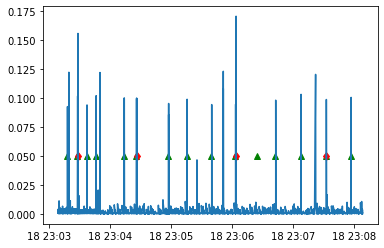

In [5]:
plt.plot(x2_compact, y2_compact, label='4096 KiB',marker='^', c='g', linestyle='')
plt.plot(x3_compact, y3_compact, label='4096 KiB',marker='d', c='r', linestyle='')
         
plt.plot(x_bs_lat, y_bs_lat, label='bluestore')
#ax.set(xlabel='time stamps', ylabel='latency [secs]', title='BlueStore Latency Time Series')
#plt.legend()
plt.show()
plt.close()

# Number of write operations between every compaction at different levels

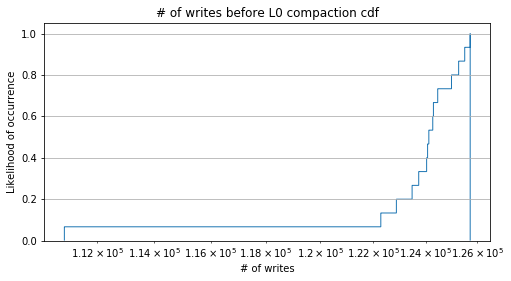

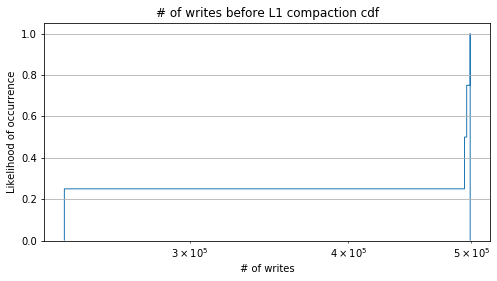

In [6]:
number_of_writes_before_flush = number_of_writes_before(x_bs_lat, x2_compact)
plot_cdf(number_of_writes_before_flush, '# of writes before L0 compaction cdf', '# of writes', x_log=True)

number_of_writes_before_compaction = number_of_writes_before(x_bs_lat, x3_compact)
plot_cdf(number_of_writes_before_compaction, '# of writes before L1 compaction cdf', '# of writes', x_log=True)

plt.close()


# Duration of every compaction at different levels

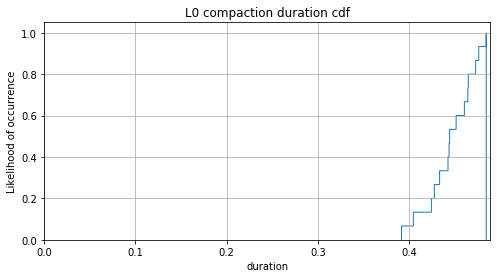

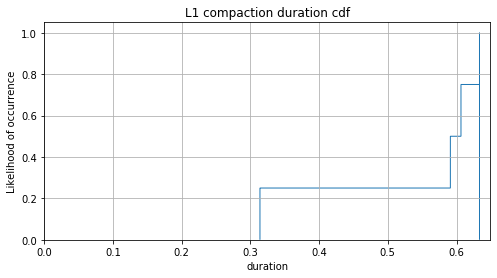

In [13]:
plot_cdf(w2_compact, 'L0 compaction duration cdf', 'duration', x_log=False)

plot_cdf(w3_compact, 'L1 compaction duration cdf', 'duration', x_log=False)

plt.close()


# (All / Not affected / Compaction affected) Latencies

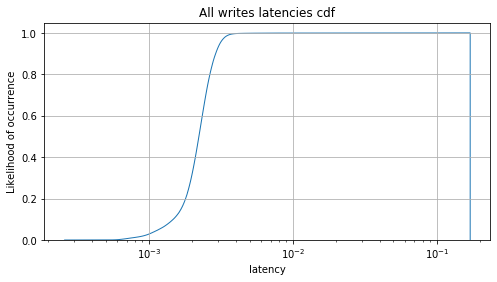

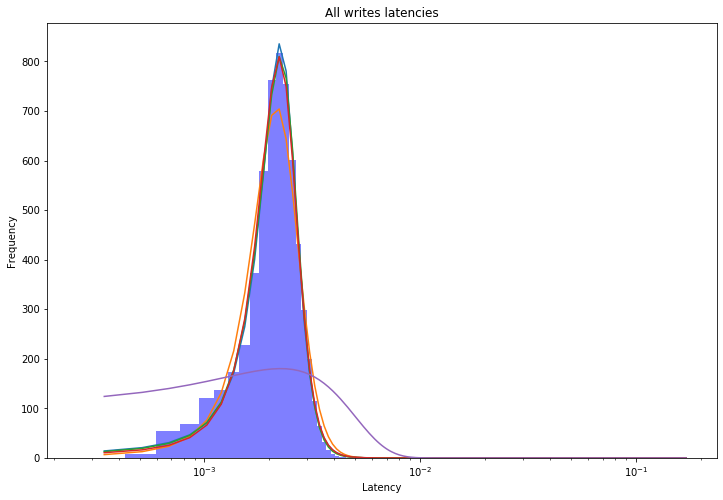

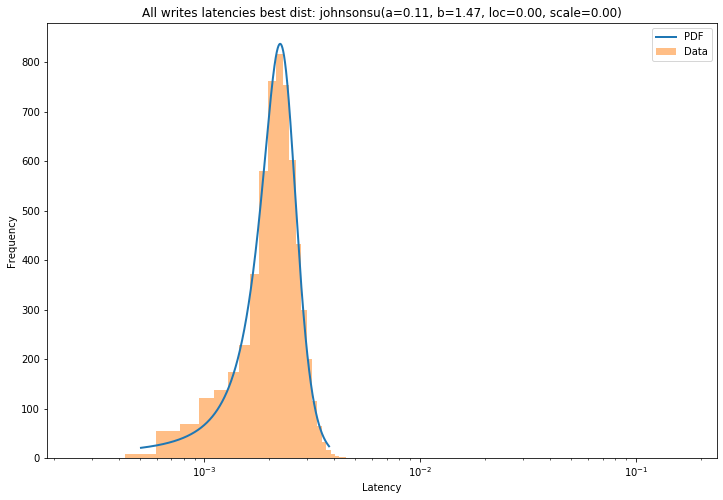

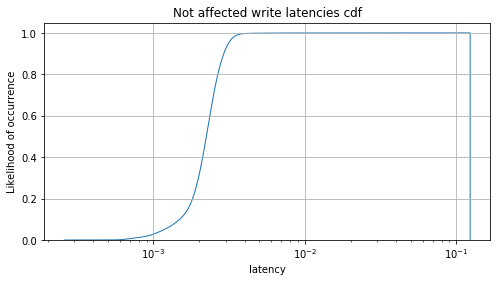

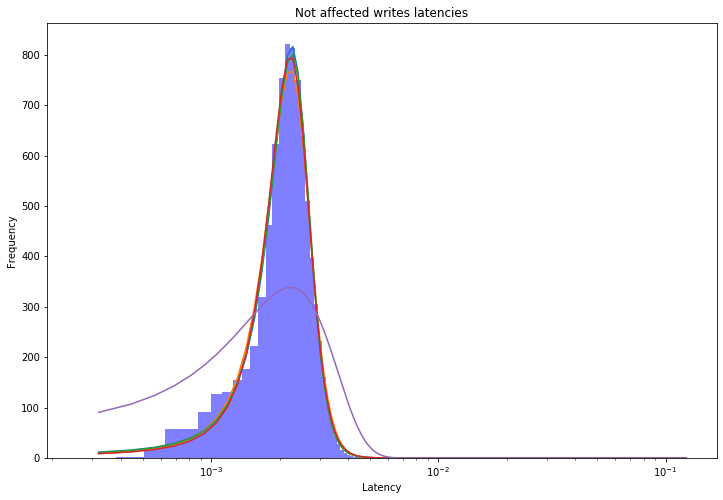

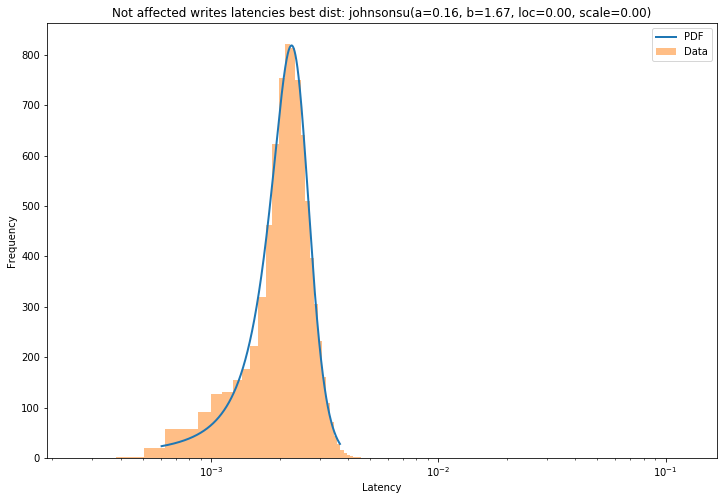

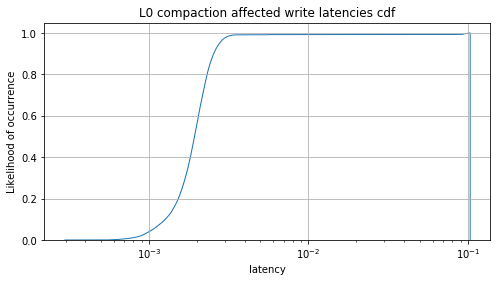

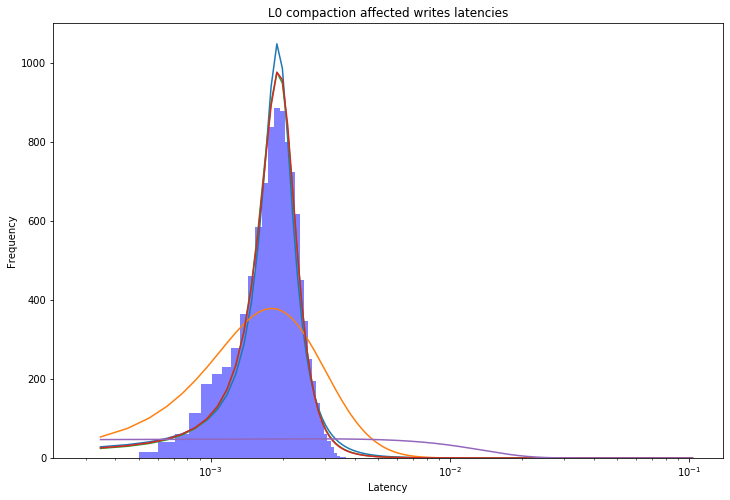

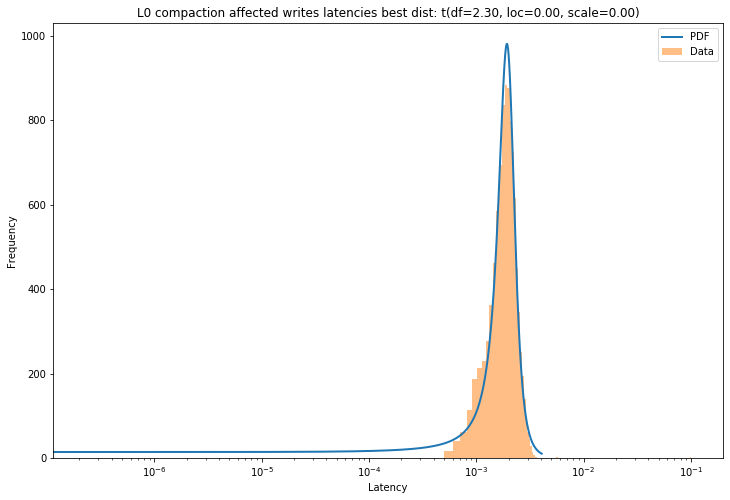

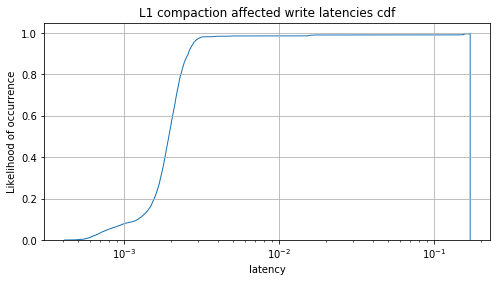

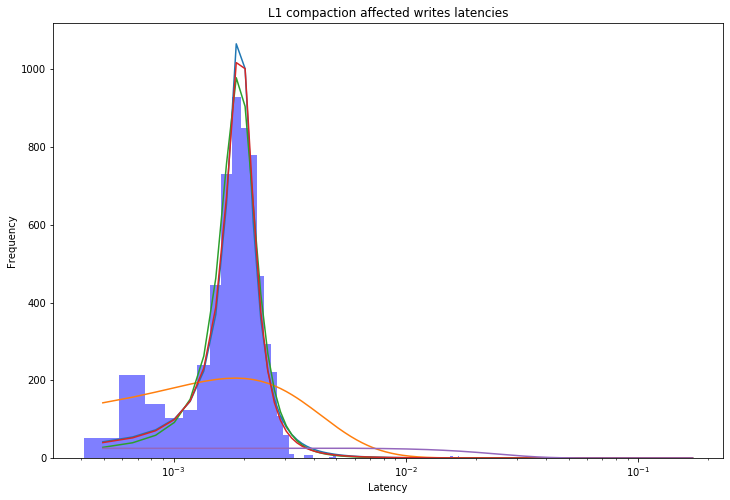

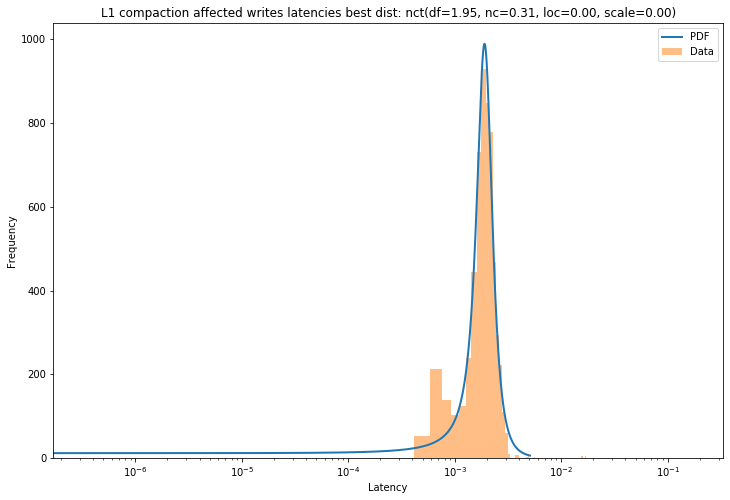

In [20]:
l0_affected_latencies, l1_affected_latencies, other_latencies = split_latencies(
    x_bs_lat, y_bs_lat, 
    x2_compact, w2_compact, 
    x3_compact, w3_compact )

plot_cdf(y_bs_lat, 'All writes latencies cdf', 'latency', x_log=True)
find_best_dist(y_bs_lat, 'All writes latencies', x_log=True)

plot_cdf(other_latencies, 'Not affected write latencies cdf', 'latency', x_log=True)
find_best_dist(other_latencies, 'Not affected writes latencies', x_log=True)

plot_cdf(l0_affected_latencies, 'L0 compaction affected write latencies cdf', 'latency', x_log=True)
find_best_dist(l0_affected_latencies, 'L0 compaction affected writes latencies', x_log=True)

plot_cdf(l1_affected_latencies, 'L1 compaction affected write latencies cdf', 'latency', x_log=True)
find_best_dist(l1_affected_latencies, 'L1 compaction affected writes latencies', x_log=True)

# Latency Model

1. **Approach 1**
    * If number of writes reaches 124,000, trigger L0 Compaction
        * L0 Compaction duration of 0.45 (median)
    * 25% of L0 Compactions trigger L1 Compaction
        * L1 Compaction duration of:
            * 20%: 0.31
            * 30%: 0.59
            * 25%: 0.6
            * 25%: 0.62
    * Write latency distribution (Not affected write latencies): Johnson SU $(a=0.16, b=1.67, loc=0, scale=0)$


2. **Approach 2**

    We can ignore compaction effect since compactions happens far less frequently than writes.
    * Write latency distribution (All write latencies): Johnson SU $(a=0.11, b=1.47, loc=0, scale=0)$
